<a href="https://colab.research.google.com/github/TheRufael/CS770-Assignments/blob/main/Assignment_Three_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Table of contents and setup
# Table of contents
# 1) Reproducibility and setup
# 2) Data load, preprocessing, and tf.data pipelines
# 3) Model builders and training utilities
# 4) Train four models (MLP no BN, MLP BN, CNN no BN, CNN BN)
# 5) Results table, learning curves, gaps, and confusion matrices

In [ ]:

# 1) Reproducibility and setup
SEED = 42
# Library imports
import os, time, random
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, utils
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
# Fix randomness across different libraries for reproducibility.
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)
# Use deterministic options when possible
try:
    tf.config.experimental.enable_op_determinism(True)
except Exception:
    pass

# Enable GPU memory growth if a GPU is available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception:
            pass
# Print environment info (versions and GPU)
print("TensorFlow", tf.__version__)
try:
    import sklearn
    print("Scikit-learn", sklearn.__version__)
except Exception:
    pass
print("Pandas", pd.__version__)
print("GPU devices", tf.config.list_physical_devices("GPU"))

TensorFlow 2.19.0
Scikit-learn 1.6.1
Pandas 2.2.2
GPU devices [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
 #  Data load, preprocessing, and tf.data pipelines

# Load the Fashion-MNIST dataset directly from keras.datasets.
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize image data to the range [0, 1] and add a channel dimension.
x_train_full = (x_train_full.astype("float32") / 255.0)[..., None]
x_test       = (x_test.astype("float32") / 255.0)[..., None]

NUM_CLASSES = 10
# One-hot encode labels

y_train_full_oh = utils.to_categorical(y_train_full, NUM_CLASSES)
y_test_oh       = utils.to_categorical(y_test, NUM_CLASSES)

# Split the full training data into training and validation sets (80/20 split) with stratification.
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full_oh, test_size=0.20, random_state=SEED, stratify=y_train_full
)

INPUT_SHAPE = (28, 28, 1)
BATCH_SIZE = 64
EPOCHS = 30

# Print the shapes of the resulting train, validation, and test sets.
print("Train", x_train.shape, "Val", x_val.shape, "Test", x_test.shape)

# Build tf.data pipelines for efficient data loading and preprocessing.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (tf.data.Dataset
            .from_tensor_slices((x_train, y_train))
            .shuffle(60000, seed=SEED, reshuffle_each_iteration=True)
            .batch(BATCH_SIZE)
            .cache()
            .prefetch(AUTOTUNE))

val_ds = (tf.data.Dataset
          .from_tensor_slices((x_val, y_val))
          .batch(BATCH_SIZE)
          .cache()
          .prefetch(AUTOTUNE))

test_ds = (tf.data.Dataset
           .from_tensor_slices((x_test, y_test_oh))
           .batch(BATCH_SIZE)
           .prefetch(AUTOTUNE))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train (48000, 28, 28, 1) Val (12000, 28, 28, 1) Test (10000, 28, 28, 1)


In [ ]:
#  Model builders and training utilities

# MLP builder with BatchNorm toggle
def build_mlp(use_bn: bool, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """
    Builds a Multi-Layer Perceptron (MLP) model with an option to include Batch Normalization.
    """
    x_in = layers.Input(shape=input_shape)
    x = layers.Flatten(name="flat")(x_in)

    x = layers.Dense(256, use_bias=not use_bn, name="dense1")(x)
    if use_bn:
        x = layers.BatchNormalization(name="bn1")(x) # Batch Normalization layer
    x = layers.Activation("relu", name="relu1")(x)

    x = layers.Dense(128, use_bias=not use_bn, name="dense2")(x)
    if use_bn:
        x = layers.BatchNormalization(name="bn2")(x) # Batch Normalization layer
    x = layers.Activation("relu", name="relu2")(x)

    out = layers.Dense(num_classes, activation="softmax", dtype="float32", name="head")(x)
    return models.Model(x_in, out, name=("mlp_with_bn" if use_bn else "mlp_no_bn"))

# CNN builder with BatchNorm toggle
def build_cnn(use_bn: bool, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """
    Builds a Convolutional Neural Network (CNN) model with an option to include Batch Normalization.
    """
    x_in = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding="same", use_bias=not use_bn, name="conv1")(x_in)
    if use_bn:
        x = layers.BatchNormalization(name="bn1")(x) # Batch Normalization layer
    x = layers.Activation("relu", name="relu1")(x)
    x = layers.MaxPooling2D(2, name="pool1")(x)

    x = layers.Conv2D(64, 3, padding="same", use_bias=not use_bn, name="conv2")(x)
    if use_bn:
        x = layers.BatchNormalization(name="bn2")(x) # Batch Normalization layer
    x = layers.Activation("relu", name="relu2")(x)
    x = layers.MaxPooling2D(2, name="pool2")(x)

    x = layers.Flatten(name="flat")(x)
    x = layers.Dense(128, use_bias=not use_bn, name="dense")(x)
    if use_bn:
        x = layers.BatchNormalization(name="bn3")(x) # Batch Normalization layer
    x = layers.Activation("relu", name="relu3")(x)

    out = layers.Dense(num_classes, activation="softmax", dtype="float32", name="head")(x)
    return models.Model(x_in, out, name=("cnn_with_bn" if use_bn else "cnn_no_bn"))

# Optimizer and compile
def compile_model(model, lr=1e-3):
    """
    Compiles a Keras model with the Adam optimizer and categorical crossentropy loss.
    """
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), # Adam optimizer
                  loss="categorical_crossentropy", # Categorical crossentropy loss
                  metrics=["accuracy"])
    return model

# Train one model and time it
def train_one(model, train_ds, val_ds, epochs=EPOCHS, verbose=2):
    """
    Trains a Keras model and measures the training time.
    """
    start = time.time()
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=verbose)
    secs = int(time.time() - start)
    return hist, secs

# Evaluate accuracy on a dataset
def evaluate_acc(model, ds):
    """
    Evaluates the accuracy of a model on a given dataset.
    """
    _, acc = model.evaluate(ds, verbose=0)
    return float(acc)

# Mean train minus val accuracy over last five epochs
def last5_gap(hist):
    """
    Calculates the mean difference between training and validation accuracy over the last 5 epochs.
    """
    a = np.array(hist.history["accuracy"][-5:])
    v = np.array(hist.history["val_accuracy"][-5:])
    return float(np.mean(a - v))

In [ ]:
# Train four models

results = [] # Initialize an empty list to store the training results.
artifacts = {} # Initialize a dictionary to store model artifacts.

# MLP without BN
tf.keras.backend.clear_session() # Clear the Keras backend session.
mlp_no_bn = build_mlp(use_bn=False) # Build MLP without BN.
compile_model(mlp_no_bn) # Compile the model.
print(mlp_no_bn.summary()) # Print summary.
hist_mlp_no_bn, t_mlp_no_bn = train_one(mlp_no_bn, train_ds, val_ds) # Train the model.
acc_test_mlp_no_bn = evaluate_acc(mlp_no_bn, test_ds) # Evaluate on test set.
results.append({
    "Model": "MLP", "BatchNorm": "No",
    "Train Acc": float(hist_mlp_no_bn.history["accuracy"][-1]),
    "Val Acc": float(hist_mlp_no_bn.history["val_accuracy"][-1]),
    "Test Acc": acc_test_mlp_no_bn,
    "Train Time (sec)": t_mlp_no_bn,
    "Params": mlp_no_bn.count_params(),
})
artifacts["mlp_no_bn"] = {"model": mlp_no_bn, "hist": hist_mlp_no_bn}

# MLP with BN
tf.keras.backend.clear_session() # Clear the Keras backend session.
mlp_bn = build_mlp(use_bn=True) # Build MLP with BN.
compile_model(mlp_bn) # Compile the model.
print(mlp_bn.summary()) # Print summary.
hist_mlp_bn, t_mlp_bn = train_one(mlp_bn, train_ds, val_ds) # Train the model.
acc_test_mlp_bn = evaluate_acc(mlp_bn, test_ds) # Evaluate on test set.
results.append({
    "Model": "MLP", "BatchNorm": "Yes",
    "Train Acc": float(hist_mlp_bn.history["accuracy"][-1]),
    "Val Acc": float(hist_mlp_bn.history["val_accuracy"][-1]),
    "Test Acc": acc_test_mlp_bn,
    "Train Time (sec)": t_mlp_bn,
    "Params": mlp_bn.count_params(),
})
artifacts["mlp_bn"] = {"model": mlp_bn, "hist": hist_mlp_bn}

# CNN without BN
tf.keras.backend.clear_session() # Clear the Keras backend session.
cnn_no_bn = build_cnn(use_bn=False) # Build CNN without BN.
compile_model(cnn_no_bn) # Compile the model.
print(cnn_no_bn.summary()) # Print summary.
hist_cnn_no_bn, t_cnn_no_bn = train_one(cnn_no_bn, train_ds, val_ds) # Train the model.
acc_test_cnn_no_bn = evaluate_acc(cnn_no_bn, test_ds) # Evaluate on test set.
results.append({
    "Model": "CNN", "BatchNorm": "No",
    "Train Acc": float(hist_cnn_no_bn.history["accuracy"][-1]),
    "Val Acc": float(hist_cnn_no_bn.history["val_accuracy"][-1]),
    "Test Acc": acc_test_cnn_no_bn,
    "Train Time (sec)": t_cnn_no_bn,
    "Params": cnn_no_bn.count_params(),
})
artifacts["cnn_no_bn"] = {"model": cnn_no_bn, "hist": hist_cnn_no_bn}

# CNN with BN
tf.keras.backend.clear_session() # Clear the Keras backend session.
cnn_bn = build_cnn(use_bn=True) # Build CNN with BN.
compile_model(cnn_bn) # Compile the model.
print(cnn_bn.summary()) # Print summary.
hist_cnn_bn, t_cnn_bn = train_one(cnn_bn, train_ds, val_ds) # Train the model.
acc_test_cnn_bn = evaluate_acc(cnn_bn, test_ds) # Evaluate on test set.
results.append({
    "Model": "CNN", "BatchNorm": "Yes",
    "Train Acc": float(hist_cnn_bn.history["accuracy"][-1]),
    "Val Acc": float(hist_cnn_bn.history["val_accuracy"][-1]),
    "Test Acc": acc_test_cnn_bn,
    "Train Time (sec)": t_cnn_bn,
    "Params": cnn_bn.count_params(),
})
artifacts["cnn_bn"] = {"model": cnn_bn, "hist": hist_cnn_bn}

Model: "mlp_no_bn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat (Flatten)                  │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head (Dense)                    │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
750/750 - 5s - 7ms/step - accuracy: 0.8193 - loss: 0.5074 - val_accuracy: 0.8457 - val_loss: 0.4299
Epoch 2/30
750/750 - 2s - 2ms/step - accuracy: 0.8649 - loss: 0.3724 - val_accuracy: 0.8615 - val_loss: 0.3813
Epoch 3/30
750/750 - 2s - 2ms/step - accuracy: 0.8780 - loss: 0.3335 - val_accuracy: 0.8722 - val_loss: 0.3548
Epoch 4/30
750/750 - 2s - 3ms/step - accuracy: 0.8870 - loss: 0.3063 - val_accuracy: 0.8791 - val_loss: 0.3362
Epoch 5/30
750/750 - 2s - 3ms/step - accuracy: 0.8936 - loss: 0.2869 - val_accuracy: 0.8833 - val_loss: 0.3343
Epoch 6/30
750/750 - 2s - 2ms/step - accuracy: 0.9000 - loss: 0.2690 - val_accuracy: 0.8817 - val_loss: 0.3390
Epoch 7/30
750/750 - 2s - 2ms/step - accuracy: 0.9055 - loss: 0.2538 - val_accuracy: 0.8841 - val_loss: 0.3317
Epoch 8/30
750/750 - 2s - 2ms/step - accuracy: 0.9090 - loss: 0.2434 - val_accuracy: 0.8814 - val_loss: 0.3435
Epoch 9/30
750/750 - 2s - 2ms/step - accuracy: 0.9125 - loss: 0.2308 - val_accuracy: 0.8793 - val_loss: 0.3

Model: "mlp_with_bn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat (Flatten)                  │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │       200,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head (Dense)                    │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,298 (923.04 KB)

 Trainable params: 235,530 (920.04 KB)

 Non-trainable params: 768 (3.00 KB)

None
Epoch 1/30
750/750 - 5s - 6ms/step - accuracy: 0.8374 - loss: 0.4590 - val_accuracy: 0.8577 - val_loss: 0.4007
Epoch 2/30
750/750 - 3s - 3ms/step - accuracy: 0.8751 - loss: 0.3370 - val_accuracy: 0.8723 - val_loss: 0.3572
Epoch 3/30
750/750 - 2s - 3ms/step - accuracy: 0.8922 - loss: 0.2905 - val_accuracy: 0.8725 - val_loss: 0.3491
Epoch 4/30
750/750 - 2s - 3ms/step - accuracy: 0.9045 - loss: 0.2562 - val_accuracy: 0.8753 - val_loss: 0.3475
Epoch 5/30
750/750 - 2s - 3ms/step - accuracy: 0.9158 - loss: 0.2273 - val_accuracy: 0.8670 - val_loss: 0.3794
Epoch 6/30
750/750 - 2s - 3ms/step - accuracy: 0.9256 - loss: 0.2010 - val_accuracy: 0.8616 - val_loss: 0.4091
Epoch 7/30
750/750 - 2s - 3ms/step - accuracy: 0.9352 - loss: 0.1779 - val_accuracy: 0.8620 - val_loss: 0.4185
Epoch 8/30
750/750 - 3s - 4ms/step - accuracy: 0.9430 - loss: 0.1577 - val_accuracy: 0.8630 - val_loss: 0.4307
Epoch 9/30
750/750 - 4s - 6ms/step - accuracy: 0.9507 - loss: 0.1388 - val_accuracy: 0.8608 - val_loss: 0.4

Model: "cnn_no_bn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat (Flatten)                  │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head (Dense)                    │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
750/750 - 7s - 10ms/step - accuracy: 0.8346 - loss: 0.4561 - val_accuracy: 0.8758 - val_loss: 0.3427
Epoch 2/30
750/750 - 3s - 3ms/step - accuracy: 0.8934 - loss: 0.2968 - val_accuracy: 0.8962 - val_loss: 0.2862
Epoch 3/30
750/750 - 3s - 4ms/step - accuracy: 0.9113 - loss: 0.2469 - val_accuracy: 0.9013 - val_loss: 0.2742
Epoch 4/30
750/750 - 2s - 3ms/step - accuracy: 0.9222 - loss: 0.2133 - val_accuracy: 0.9109 - val_loss: 0.2559
Epoch 5/30
750/750 - 2s - 3ms/step - accuracy: 0.9317 - loss: 0.1861 - val_accuracy: 0.9111 - val_loss: 0.2650
Epoch 6/30
750/750 - 3s - 3ms/step - accuracy: 0.9412 - loss: 0.1625 - val_accuracy: 0.9153 - val_loss: 0.2615
Epoch 7/30
750/750 - 3s - 4ms/step - accuracy: 0.9501 - loss: 0.1401 - val_accuracy: 0.9194 - val_loss: 0.2594
Epoch 8/30
750/750 - 5s - 7ms/step - accuracy: 0.9581 - loss: 0.1192 - val_accuracy: 0.9170 - val_loss: 0.2694
Epoch 9/30
750/750 - 3s - 3ms/step - accuracy: 0.9648 - loss: 0.1010 - val_accuracy: 0.9179 - val_loss: 0.

Model: "cnn_with_bn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat (Flatten)                  │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head (Dense)                    │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,314 (1.61 MB)

 Trainable params: 421,866 (1.61 MB)

 Non-trainable params: 448 (1.75 KB)

None
Epoch 1/30
750/750 - 8s - 11ms/step - accuracy: 0.8731 - loss: 0.3573 - val_accuracy: 0.9004 - val_loss: 0.2800
Epoch 2/30
750/750 - 3s - 4ms/step - accuracy: 0.9174 - loss: 0.2251 - val_accuracy: 0.9109 - val_loss: 0.2550
Epoch 3/30
750/750 - 3s - 4ms/step - accuracy: 0.9387 - loss: 0.1704 - val_accuracy: 0.9118 - val_loss: 0.2487
Epoch 4/30
750/750 - 3s - 4ms/step - accuracy: 0.9550 - loss: 0.1289 - val_accuracy: 0.9044 - val_loss: 0.2924
Epoch 5/30
750/750 - 3s - 4ms/step - accuracy: 0.9677 - loss: 0.0952 - val_accuracy: 0.9082 - val_loss: 0.2994
Epoch 6/30
750/750 - 3s - 4ms/step - accuracy: 0.9767 - loss: 0.0700 - val_accuracy: 0.9115 - val_loss: 0.3004
Epoch 7/30
750/750 - 3s - 4ms/step - accuracy: 0.9815 - loss: 0.0555 - val_accuracy: 0.9088 - val_loss: 0.3350
Epoch 8/30
750/750 - 3s - 4ms/step - accuracy: 0.9845 - loss: 0.0462 - val_accuracy: 0.9060 - val_loss: 0.3414
Epoch 9/30
750/750 - 3s - 4ms/step - accuracy: 0.9871 - loss: 0.0386 - val_accuracy: 0.9141 - val_loss: 0.

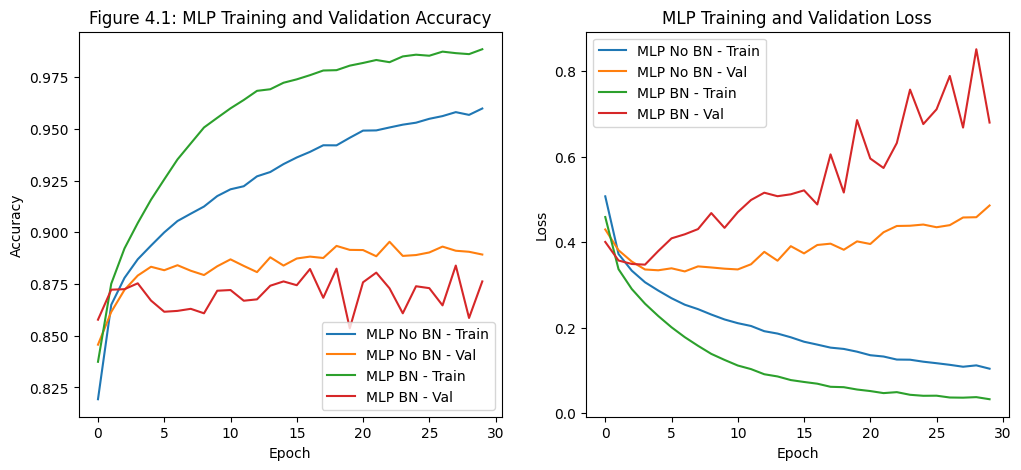

In [ ]:
import matplotlib.pyplot as plt

# ===============================
# Figure 4.1 — MLP Learning Curves
# ===============================

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(hist_mlp_no_bn.history["accuracy"], label="MLP No BN - Train")
plt.plot(hist_mlp_no_bn.history["val_accuracy"], label="MLP No BN - Val")
plt.plot(hist_mlp_bn.history["accuracy"], label="MLP BN - Train")
plt.plot(hist_mlp_bn.history["val_accuracy"], label="MLP BN - Val")
plt.title("Figure 4.1: MLP Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(hist_mlp_no_bn.history["loss"], label="MLP No BN - Train")
plt.plot(hist_mlp_no_bn.history["val_loss"], label="MLP No BN - Val")
plt.plot(hist_mlp_bn.history["loss"], label="MLP BN - Train")
plt.plot(hist_mlp_bn.history["val_loss"], label="MLP BN - Val")
plt.title("MLP Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


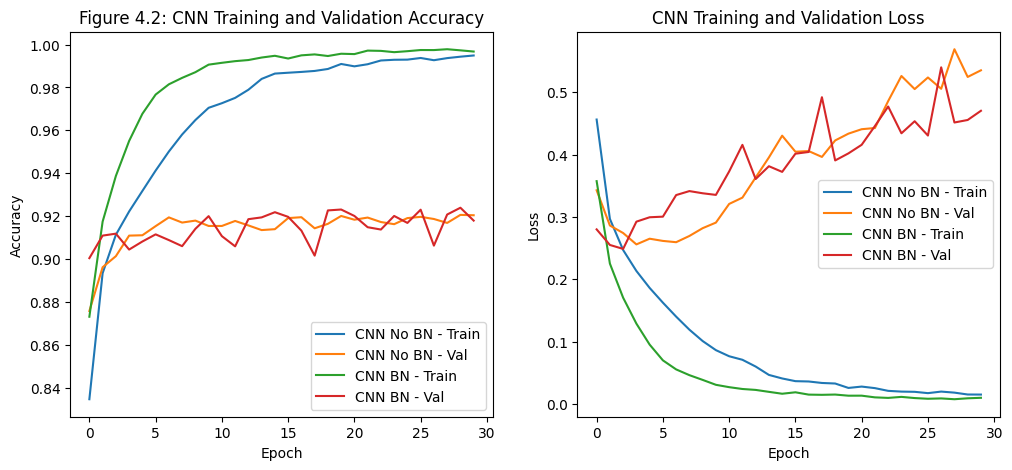

In [ ]:
# ===============================
# Figure 4.2 — CNN Learning Curves
# ===============================

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(hist_cnn_no_bn.history["accuracy"], label="CNN No BN - Train")
plt.plot(hist_cnn_no_bn.history["val_accuracy"], label="CNN No BN - Val")
plt.plot(hist_cnn_bn.history["accuracy"], label="CNN BN - Train")
plt.plot(hist_cnn_bn.history["val_accuracy"], label="CNN BN - Val")
plt.title("Figure 4.2: CNN Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(hist_cnn_no_bn.history["loss"], label="CNN No BN - Train")
plt.plot(hist_cnn_no_bn.history["val_loss"], label="CNN No BN - Val")
plt.plot(hist_cnn_bn.history["loss"], label="CNN BN - Train")
plt.plot(hist_cnn_bn.history["val_loss"], label="CNN BN - Val")
plt.title("CNN Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
